# Approximating Pi
We are given a stream of $U(0,1)$ random variables.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Using Spheres
### The base case: The circle
We are treating pairs of random variables as points in the unit square, and then check how many land in the quarter of the unit circle. This will approximate $\pi/4$
Let us start with 100 points

In [2]:
np.random.seed(1)
u = np.random.uniform
def isInCircle(x,y):
    return (1 if x**2+y**2 <=1 else 0)
def circleMethod(n):
    x = u(0,1,n)
    y = u(0,1,n)
    isInCircle = (x**2+y**2<=1)*1
    return 4*np.mean(isInCircle)
circleMethod(100)

3.08

However now we can ask ourselves: How *good* is our approximation? Since we are approximating $\pi$, we cannot simply compare it to the *true* result, that would be circular. Instead we can try to measure the *standard deviation* or *variance*. Note that the theoretical variance for $n$ points would be $\frac{\pi/4 \cdot (1-\pi/4)}{n}$.

In [3]:
def sampleStd(approximator):
    return (lambda n,m:np.ma.std([approximator(n) for k in range(m)]))

Let's see how the standard deviation changes with $n$ and $m$ (depending on your machine this might take a moment. Feel free to lower the value of $m$).

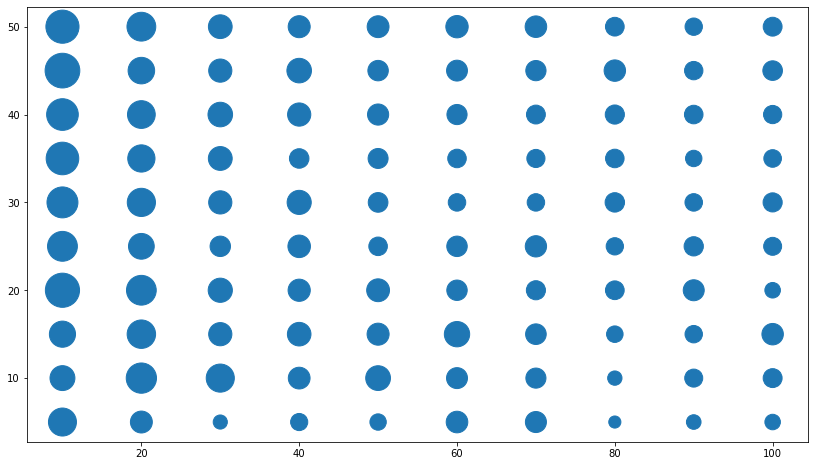

In [4]:
np.random.seed(1)
steps = 10
ns=range(10,10*steps+1,10)
ms=np.array(range(5,5*steps+1,5))
x,y=np.meshgrid(ns,ms)
#size=np.array([[sampleStd(quarterCircleMethod)(m,n) for n in ns] for m in ms])
vectorizedStd=np.vectorize(sampleStd(circleMethod))
size=vectorizedStd(x,y)
normalized_size = size / np.max(size)
plt.figure(figsize=(14,8))
plt.scatter(x,y,s=size*2000)
plt.show()

We see that the standard deviation only depends on $n$ and is largely independent of $m$, except that it gives us a more accurate result *for the standard deviation, not for the approximation of $\pi$*, therefore along the $m$-axis we see circles of roughly the same size. On the other hand when we are looking at one row, there is a steady decrease in size for larger $m$ while for small $m$ the circle size actually fluctuates.

### Higher dimensions
Next we want to see if bigger dimensions make the estimate more or less efficient. Note that we need $d$ random variables to get one point of dimension $d$, so if they are a scarse ressource this should be considered independently. For now we will compare different dimensions on the basis of sampling the same number of points.

The proportion the unit sphere takes in the unit cube gets smaller with higher dimensions. This is immediately obvious since as $d$ gets bigger the probability of $x_1^2 +\ldots+x_d^2\leq 1$ gets smaller.

Additionally if we knew the exact proportion of the unit sphere in the unit cube, who even knows the formulas to get $\pi$ from that? I didn't know the general formula for the volume $V_d$ of the unit sphere in $\mathbb{R}^d$, before looking it up. Here it is by the way, copied from [Wikipedia](https://en.wikipedia.org/wiki/Unit_sphere)
$$
V_d = \frac{\pi ^ {d/2}}{\Gamma(1+d/2)} = \begin{cases}
{\pi^{d/2}}/{(d/2)!} & \mathrm{if~}n \ge 0\mathrm{~is~even,} \\
~\\
{\pi^{\lfloor d/2 \rfloor}2^{\lceil d/2 \rceil}}/{d!!} & \mathrm{if~}n \ge 0\mathrm{~is~odd,}
\end{cases} 
$$

Recall that $n!!$ is the *double factorial* and you compute it by multiplying every second number including $n$. I.e.
$$
8!! = 8\cdot 6\cdot 4\cdot 2 \text{ and } 9!! = 9\dot 7 \cdot 5\cdot 3\cdot 1.
$$
So we need to multiply our result by a rapidly growing number, $(d/2)!$ or $d!!$, then by another rapidly growing number $2^d$, because there are $2^d$ unit cubes with $0$ as a vertex, and then take a linearly growing rood $d/2$. 
This will probably add some more error into our estimate.

In [5]:
def convertEstimate(dim,est):
    # Given an estimate for the fraction of the unit sphere in the unit cube
    # What estimate of pi does this correspond to?
    vol = est*(2**dim)
    return np.power(vol*np.math.gamma(1+dim/2),2/dim)
def point(d):
    return u(0,1,d)
def sphereMethod(dim):
    return (lambda n:convertEstimate(dim,np.mean([(sum(point(dim)**2)<=1)*1 for _ in range(n)])))

As a sanity let's check the 2-dimensional result against what we already have. We can see that they just fluctuate randomly, and that the fluctuation gets smaller if we increase the number of sampling points.

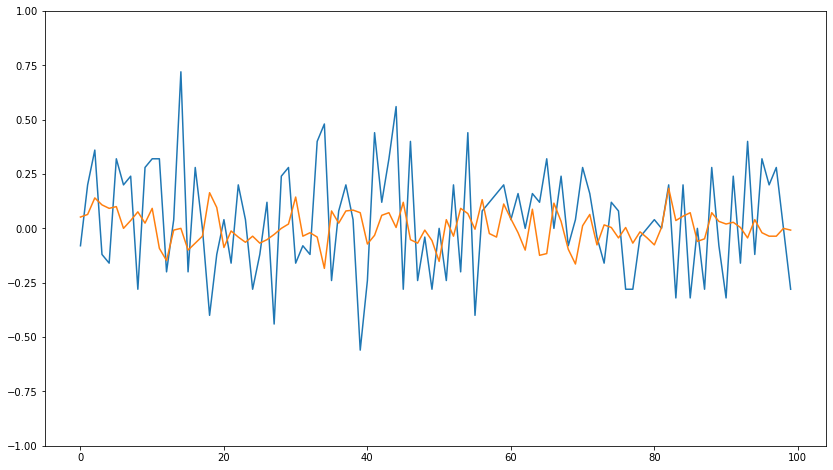

In [6]:
np.random.seed(1)
plt.figure(figsize=(14,8))
plt.ylim((-1,1))
plt.plot([sphereMethod(2)(100)-circleMethod(100) for _ in range(100)])
plt.plot([sphereMethod(2)(1000)-circleMethod(1000) for _ in range(100)])
plt.show()

Now we can start comparing the different dimensions.

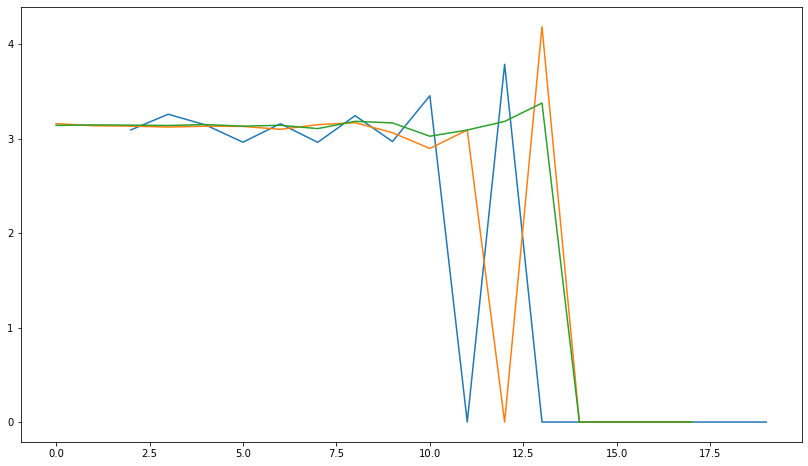

In [19]:
np.random.seed(1)
numOfSamples = 1000
dims=range(2,20)
plt.figure(figsize=(14,8))
plt.plot(dims,[sphereMethod(d)(numOfSamples) for d in dims])
plt.plot(dims,[sphereMethod(d)(numOfSamples*10) for d in dims])
plt.plot(dims,[sphereMethod(d)(numOfSamples*100) for d in dims])
plt.show()

It seems that after dimension 10 we are running into problems with the computations. In dimension 11 each point we sample from the unit cube only has a chance of roughly $0.09\%$ to land in the unit sphere. Therefore with only 1000 points sampled, it is not unlikely to not get a single point in the sphere.

Next we plot the dimension against the standard deviation. Recall that for a Bernoulli trial the standard deviation is $\sqrt{p(1-p)}$. When sampling $n$ points we get $\sqrt{np(1-p)}$ and since we divide by $n$ when taking the mean we get $\sqrt{\frac{p(1-p}{n}}$. In our case $p$ is the probability that a random point falls within the circle, i.e. $V_d/2^d$. This goes towards zero, therefore the standard deviation also tends towards zero. We will see how this pans out in the graph below.
Depending on your machine, it might take a while to compute. Feel free to decrease some of the parameters

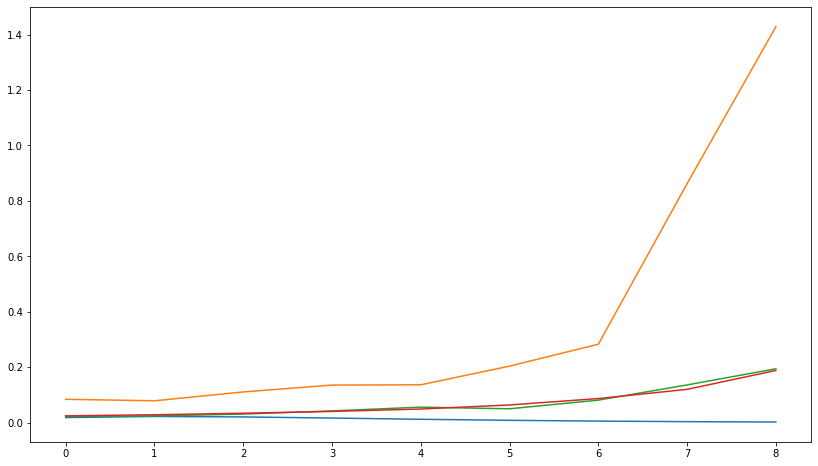

In [13]:
np.random.seed(1)
def theoreticalStd(d,n):
    p = np.power(np.math.pi,d/2)/(np.math.gamma(1+d/2)*2**d)
    return np.sqrt(p*(1-p)/n)
numOfSamples = 500
numOfRounds = 60
dims=range(2,11)
plt.figure(figsize=(14,8))
plt.plot(dims,[theoreticalStd(d,numOfSamples) for d in dims])
plt.plot(dims,[sampleStd(sphereMethod(d))(numOfSamples,numOfRounds) for d in dims])
plt.plot(dims,[sampleStd(sphereMethod(d))(numOfSamples*10,numOfRounds) for d in dims])
plt.plot(dims,[sampleStd(sphereMethod(d))(numOfSamples*10,numOfRounds*10) for d in dims])
plt.show()

As we can see even though the theoretical standard deviation goes down, with only a small number of samples we get a bigger standard deviation. Also the red and green line are almost identical, suggesting that we didn't just get unlucky in our 60 rounds.

## Using Integrals
What we have done with spheres is similar to actually computing the integral $\int_0^1 \sqrt{1-x^2} dx$.
However now we want to compute our approach with Monte-Carlo Integration. In essence we will sample the function at random points, and take the average of their function values.

In [109]:
np.random.seed(1)
numOfSamples=500
def monteCarloInt(f,n):
    xs = u(0,1,n)
    return np.mean(list(map(f,xs)))
4*monteCarloInt(lambda x: np.sqrt(1-x**2),numOfSamples)

3.174359915611043

## Using Buffon's Needle

[Buffon's Needle](https://en.wikipedia.org/wiki/Buffon%27s_needle_problem) is a well-known problem in probability theory. On an infinite surface we have parallel, vertical lines, let's say at $x=t$ for $t\in \mathbb{Z}$. We then trow a needle with unit length. Then the probability that the needle crosses a line is $2/\pi$. 
~~The intuitive approach is to generate a point in the unit square which we interpret as the starting point of the needle, and then a second point giving the direction from that point.
However, since we can simply shift the setup along the $y$-direction, we can assume that one point of the needle lands on the $y=0$ line, therefore we only need 1 point for the first tip of the needle. This will make comparision more fair once we start treating random variables as a scarce ressource.~~

~~Let us quickly do the math before going into code.
Given a starting point $(x_0,0)$ and another point $(x_1,y_1)$, we get a right triangle with vertices $(x_0,0)$, $(x_1,0)$, and $(x_1,y_1)$. One side has length $|x_0-x_1|$ and the other has length $y_1$ (noting that all numbers are in $[0,1]$). Therefore the long edge has length $c:=\sqrt{y_1^2+(x_0-x_1)^2}$. Now our needle has unit length, so we want to scale the triangle by the length of the long edge. Then the needle touches a line if $x_0+\frac{x_1-x_0}{c}$ is bigger than $1$ or smaller than $0$.~~

In [95]:
def wrongNeedleMethod(n):
    x0s=u(0,1,n)
    x1s=u(0,1,n)
    y1s=u(0,1,n)
    return 2/np.mean([not(0<=x0+(x1-x0)/np.sqrt(y1**2+(x0-x1)**2)<=1)*1 for x0,x1,y1 in zip(x0s,x1s,y1s)])
needleMethod(100000)

6.023007890140335

This seems to not be working. It might be the case that the distribution is not uniform. Let's test it. In the Wikipedia article the distance from the needle midpoint to the closes parallel line, as well as the acute angle between the parallel lines and the needle are assumed to be uniformly distributed.

Since our triangle is a right triangle, the midpoint of the needle is at 
$$x_0+\frac{x_1-x_0}{c}$$

(array([  1.,   9.,   9.,  27.,  80.,  87., 133., 175., 221., 258.]),
 array([-0.32305115, -0.24075528, -0.15845941, -0.07616354,  0.00613233,
         0.0884282 ,  0.17072407,  0.25301994,  0.33531581,  0.41761168,
         0.49990755]),
 <a list of 10 Patch objects>)

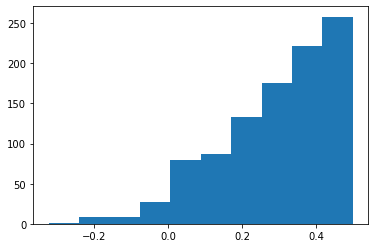

In [104]:
def distanceToMidpoints(n):
    x0s=u(0,1,n)
    x1s=u(0,1,n)
    y1s=u(0,1,n)
    midpoints = [x0+(x1-x0)/(2*np.sqrt(y1**2+(x0-x1)**2)) for x0,x1,y1 in zip(x0s,x1s,y1s)]
    return [min([mp,1-mp]) for mp in midpoints]
plt.hist(distanceToMidpoints(1000))

And indeed we see that this is not uniformly distributed. I will leave this here for now as a tribute to my wrongness.